# Introduction

This is a short example of how to use the [SUNDIALS](https://computing.llnl.gov/projects/sundials) to solve
a simple partial differential equation in Haskell via the [hmatrix-sundials](http://hackage.haskell.org/package/hmatrix-sundials)
library. The example is taken from the C examples that come with the SUNDIALS source.

# A Bit of Theory

Consider the heat equation. With one spatial dimension we have:

$$
\frac{\partial u}{\partial t}=k \frac{\partial^{2} u}{\partial x^{2}}+f
$$

where $k$ is some diffusion coefficient.

Let's take $t \in [0,10]$ and $x \in [0,1]$ with initial condition $u(0, x)=0$.

Stationary boundary conditions

$$
\frac{\partial u}{\partial t}(t, 0)=\frac{\partial u}{\partial t}(t, 1)=0
$$

And a point heat source

$$
f(t, x)=\left\{\begin{array}{ll}{1} & {\text { if } x=1 / 2} \\ {0} & {\text { otherwise }}\end{array}\right.
$$

and we can discretize over this spatial dimension using:

$$
u_{x x}=\frac{u_{j+1}-2 u_{j}+u_{j-1}}{\Delta x^{2}}
$$

where

$$
u_{j}(t) \triangleq u\left(t, x_{j}\right), \quad x_{j} \triangleq j \Delta x, \quad 0 \leq j \leq n+1
$$



We can write this in matrix form

$$
\dot{u}_i = \sum_0^{n+1} A_{i\,j} u_j + B_i, \quad 0 \leq i \leq n+1
$$

where

$$
\begin{aligned}
A_{0\,j}     = 0, & \quad 0 \leq j \leq n+1, & \text{boundary condition} \\
A_{i\,i-1}   = 1  &                          &                           \\
A_{i\,i}     = 2  &                          &                           \\
A_{i\,i+1}   = 1  &                          &                           \\
A_{{n+1}\,j} = 0, & \quad 0 \leq j \leq n+1, & \text{boundary condition} \\
A_{i\,j}     = 0  & \quad \text{otherwise}   &                           \\
\end{aligned}
$$

Converting this to a system of ODEs is straightforward, for example

$$
\begin{bmatrix}
\dot{u_0} \\
\dot{u_1} \\
\dot{u_2} \\
\dot{u_3} \\
\dot{u_4}
\end{bmatrix}
=
\begin{bmatrix}
0 &  0 &  0 &  0 & 0 \\
1 & -2 &  1 &  0 & 0 \\
0 &  1 & -2 &  1 & 0 \\
0 &  0 &  1 & -2 & 1 \\
0 &  0 &  0 &  0 & 0
\end{bmatrix}
\begin{bmatrix}
u_0 \\
u_1 \\
u_2 \\
u_3 \\
u_4
\end{bmatrix}
+
\begin{bmatrix}
f_0 \\
f_1 \\
f_2 \\
f_3 \\
f_4
\end{bmatrix}
$$

where $f_j \triangleq f(t, x_j)$.

# Implementation

In [1]:
import           Numeric.Sundials.ARKode.ODE
import           Numeric.LinearAlgebra

Spatial mesh size

In [2]:
bigN :: Int
bigN = 201

Heat conductivity

In [3]:
k :: Double
k = 0.5

Mesh spacing

In [4]:
deltaX :: Double
deltaX = 1.0 / (fromIntegral bigN - 1)
c1, c2 :: Double
c1 = k / deltaX / deltaX
c2 = (-2.0) * k / deltaX / deltaX

Initial time

In [5]:
t0 :: Double
t0 = 0.0

Final time

In [6]:
tf :: Double
tf =1.0

Total number of output times

In [7]:
bigNt :: Int
bigNt = 10

Timesteps

In [8]:
deltaT :: Double
deltaT = (tf - t0) / (fromIntegral bigNt)

Relative tolerance

In [9]:
rtol :: Double
rtol = 1.0e-6

Absolute tolerance

In [10]:
atol :: Double
atol = 1.0e-10

In [11]:
bigA :: Matrix Double
bigA = assoc (bigN, bigN) 0.0 [ ((i, j), f (i, j)) | i <- [0 .. bigN - 1]
                                                   , j <- [0 .. bigN - 1]
                        ]
 where
   f (i, j) | i     == 0        = 0.0    -- left boundary condition
            | i     == bigN - 1 = 0.0    -- right boundary condition
            | i     == j        = c2
            | i - 1 == j        = c1
            | i + 1 == j        = c1
            | otherwise         = 0.0

In [12]:
b :: Vector Double
b = assoc bigN 0.0 [ (iSource, 0.01 / deltaX) ]
  where
    iSource = bigN `div` 2

Initial condition

In [13]:
bigU0 :: Vector Double
bigU0 = assoc bigN 0.0 []

Finally we get to solve the system of equations

In [14]:
sol :: Matrix Double
sol = odeSolveV SDIRK_5_3_4' Nothing rtol atol (const bigU') bigU0 (vector (map (deltaT *) [0 .. 10]))
  where
    bigU' bigU = bigA #> bigU + b

We can draw the results on a chart using the [diagrams](http://hackage.haskell.org/package/diagrams)
and [Chart](http://hackage.haskell.org/package/Chart) packages.

In [18]:
import Diagrams.Prelude
import Graphics.Rendering.Chart
import Data.Default.Class
import Control.Lens

In [26]:
chart t l obss = toRenderable layout
  where

    actual x l c = plot_lines_values .~ [x]
                   $ plot_lines_style  . line_color .~ opaque c
                   $ plot_lines_title .~ l
                   $ plot_lines_style  . line_width .~ 1.0
                   $ def

    ls = map (\n -> "Time " ++ show (deltaT * fromIntegral n)) [0..]
    cs = cycle [blue, green, red]

    actuals' :: [PlotLines Double Double]
    actuals' = zipWith3 actual obss ls cs

    layout = layout_title .~ t
           $ layout_plots .~ map toPlot actuals'
           $ layout_y_axis . laxis_title .~ l
           $ layout_y_axis . laxis_override .~ axisGridHide
           $ layout_x_axis . laxis_title .~ "Time"
           $ layout_x_axis . laxis_override .~ axisGridHide
           $ def

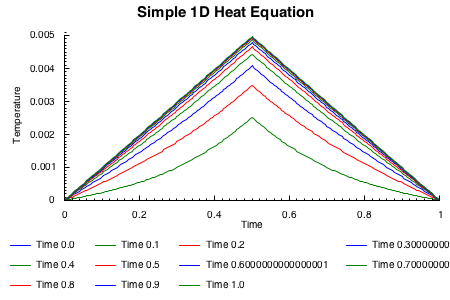

In [27]:
chart "Simple 1D Heat Equation" "Temperature"
      (map (zip (map ((* deltaX) . fromIntegral) [0 .. bigN]) . toList) (toRows sol))

# Coda

 I have included the C and its accompanying Python script which draws charts of the results in the [github repo](https://github.com/idontgetoutmuch/NumMethHaskell/tree/master/Prediction).

I was able to compile and run the SUNDIALS example like this

```
nix-shell -p sundials
gcc ark_heat1D.c -lsundials_arkode -lm
./a.out
python plot_heat1D.py
```